In [1]:
!git clone https://github.com/Soham-Gaonkar/BubbleSegmentation.git

Cloning into 'BubbleSegmentation'...


Updating files: 100% (2599/2599), done.
Error downloading object: best_model.pth (4cea464): Smudge error: Error downloading best_model.pth (4cea464e4f2a8cae5d9a6c343b9c9a5ea94978b5c2d891f284526e3d009f4940): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /teamspace/studios/this_studio/BubbleSegmentation/.git/lfs/logs/20250412T133510.304118671.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: best_model.pth: smudge filter lfs failed
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'



⚡️ Tip	Connect GitHub to Studios: https://lightning.ai/23110065/home?settings=integrations



In [1]:
# STEP 0: Imports
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import matplotlib.pyplot as plt


# STEP 1: Custom Dataset for Bubble Images
import random
from torchvision.transforms import functional as TF

import random
from torchvision.transforms import functional as TF
from torchvision import transforms

class BubbleDataset(Dataset):
    def __init__(self, image_paths, label_paths, augment=False):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def center_crop(self, img, target_width=750, target_height=554):
        w, h = img.size
        left = (w - target_width) // 2
        top = (h - target_height) // 2
        right = left + target_width
        bottom = top + target_height
        return img.crop((left, top, right, bottom))

    def __getitem__(self, idx):
        # Load original image
        image = Image.open(self.image_paths[idx]).convert('L')
        label = Image.open(self.label_paths[idx])

        # Keep copy before any cropping/resizing
        original_image = image.copy()  # PIL Image (single-channel)

        # Center Crop
        image = self.center_crop(image, target_width=750)
        label = self.center_crop(label, target_width=750)

        # Resize to model input
        image = TF.resize(image, (256, 256))
        label = TF.resize(label, (256, 256), interpolation=Image.NEAREST)

        if self.augment:
            if random.random() > 0.5:
                image = TF.hflip(image)
                label = TF.hflip(label)
            if random.random() > 0.5:
                image = TF.vflip(image)
                label = TF.vflip(label)
            if random.random() > 0.5:
                angle = random.uniform(-5, 5)
                image = TF.rotate(image, angle)
                label = TF.rotate(label, angle, interpolation=Image.NEAREST)

            # Brightness / Contrast
            if random.random() > 0.5:
                image = TF.adjust_brightness(image, random.uniform(0.9, 1.1))
            if random.random() > 0.5:
                image = TF.adjust_contrast(image, random.uniform(0.9, 1.1))

            # Random Crop & Resize (mild zoom)
            if random.random() > 0.5:
                i, j, h, w = transforms.RandomResizedCrop.get_params(
                    image, scale=(0.9, 1.0), ratio=(1.0, 1.0))
                image = TF.resized_crop(image, i, j, h, w, (256, 256))
                label = TF.resized_crop(label, i, j, h, w, (256, 256), interpolation=Image.NEAREST)

            # Gaussian Noise
            if random.random() > 0.5:
                img_tensor = TF.to_tensor(image)
                noise = torch.randn_like(img_tensor) * 0.01
                img_tensor = (img_tensor + noise).clamp(0, 1)
                image = TF.to_pil_image(img_tensor)


        image = TF.to_tensor(image)
        image = image.expand(3, -1, -1)
        label = TF.pil_to_tensor(label).squeeze().long()
        label = (label > 127).long()

        return image, label


# STEP 2: Parsing and Splitting Data Based on Dataset Number
all_images = sorted(glob.glob('BubbleSegmentation/Data/US_2/*.jpg'))
all_labels = [img_path.replace('US', 'Label').replace('.jpg', '.png') for img_path in all_images]


print("Sample image:", all_images[0])
print("Sample label:", all_labels[0])

img = Image.open(all_images[0])
lbl = Image.open(all_labels[0])

print("Image size:", img.size)
print("Label size:", lbl.size)


# Extract dataset number (last digit before .jpg)
def extract_dataset_number(path):
    return int(path.split('_')[-1].split('.')[0])

def extract_pulse_number(path):
    return int(path.split('US')[1].split('_')[0])

groups = [extract_dataset_number(p) for p in all_images]

splitter = GroupShuffleSplit(n_splits=1, test_size=1/6)
print("Number of unique groups:", len(np.unique(groups)))
train_idx, val_idx = next(splitter.split(all_images, groups=groups))

# train_idx = np.concatenate([train_idx, val_idx])


train_images = [all_images[i] for i in train_idx]
train_labels = [all_labels[i] for i in train_idx]
val_images = [all_images[i] for i in val_idx]
val_labels = [all_labels[i] for i in val_idx]



print( np.array(set([extract_dataset_number(p) for p in train_images])))
print( np.array(set([extract_dataset_number(p) for p in val_images])))

print("Sample mapping:")
for img, lbl in zip(train_images[:3], train_labels[:3]):
    print(f"{img}  -->  {lbl}")


# STEP 3: Transforms
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


train_dataset = BubbleDataset(train_images, train_labels, augment=True)
val_dataset = BubbleDataset(val_images, val_labels, augment=False)


train_datasets = sorted(set(extract_dataset_number(p) for p in train_images))
val_datasets = sorted(set(extract_dataset_number(p) for p in val_images))

print("Train dataset numbers:", train_datasets)
print("Validation dataset numbers:", val_datasets)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

img_batch, lbl_batch = next(iter(train_loader))
print("Image shape:", img_batch.shape)   # [B, 3, 256, 256]
print("Label shape:", lbl_batch.shape)   # [B, 256, 256]
print("Label dtype:", lbl_batch.dtype)   # should be torch.int64
print("Label values:", lbl_batch.unique())  # should be tensor([0, 1])

Sample image: BubbleSegmentation/Data/US_2/t3US100_738966_1.jpg
Sample label: BubbleSegmentation/Data/Label_2/t3Label100_738966_1.png
Image size: (1024, 256)
Label size: (1024, 256)
Number of unique groups: 6
{1, 2, 4, 5, 6}
{3}
Sample mapping:
BubbleSegmentation/Data/US_2/t3US100_738966_1.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label100_738966_1.png
BubbleSegmentation/Data/US_2/t3US100_738966_2.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label100_738966_2.png
BubbleSegmentation/Data/US_2/t3US100_738966_4.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label100_738966_4.png
Train dataset numbers: [1, 2, 4, 5, 6]
Validation dataset numbers: [3]
Image shape: torch.Size([16, 3, 256, 256])
Label shape: torch.Size([16, 256, 256])
Label dtype: torch.int64
Label values: tensor([0, 1])


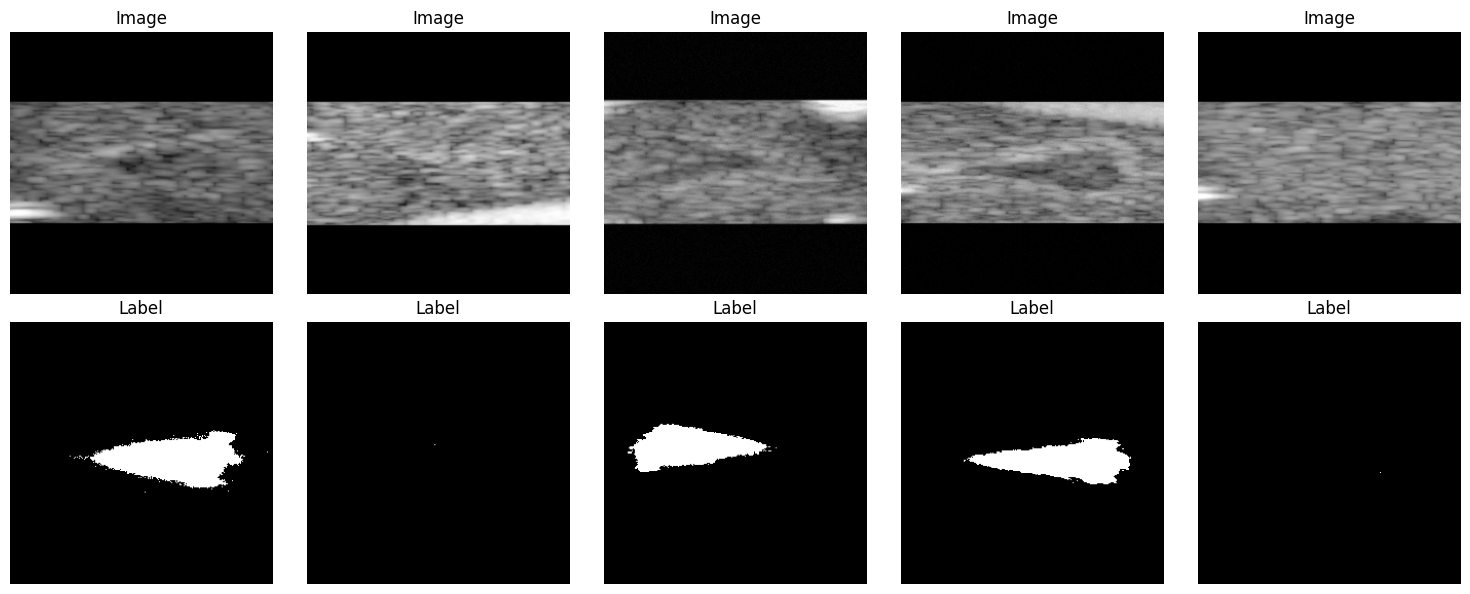

In [ ]:
def show_images(img_batch, lbl_batch, num_samples=5):
    plt.figure(figsize=(num_samples * 3, 6))

    for i in range(num_samples):
        img = img_batch[i][0].cpu().numpy()  # take 1st channel directly (no permute needed)
        lbl = lbl_batch[i].cpu().numpy()

        # Image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title("Image")

        # Label
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(lbl, cmap='gray')
        plt.axis('off')
        plt.title("Label")

    plt.tight_layout()
    plt.show()

img_batch, lbl_batch = next(iter(train_loader))
show_images(img_batch, lbl_batch)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os, glob, re
import numpy as np
from PIL import Image, ImageEnhance
from tqdm import tqdm
import random

# ---- Loss Functions ----
class AsymmetricTverskyLoss(nn.Module):
    def __init__(self, delta=0.7, smooth=1e-6, class_weights=None):
        """
        delta > 0.5 penalizes false negatives more (good for segmentation)
        class_weights: tensor of shape (num_classes,), e.g., [background_weight, foreground_weight]
        """
        super().__init__()
        self.delta = delta
        self.smooth = smooth
        self.class_weights = class_weights

    def forward(self, preds, targets):
        # preds shape: (batch, num_classes, H, W)
        preds = F.softmax(preds, dim=1)  # probability over classes

        # Assume binary segmentation: background (0), foreground (1)
        foreground_preds = preds[:, 1, :, :]  # shape: (batch, H, W)
        background_preds = preds[:, 0, :, :]  # shape: (batch, H, W)

        foreground_targets = (targets == 1).float()
        background_targets = (targets == 0).float()

        # True Positives, False Negatives, False Positives for foreground
        true_pos_fg  = (foreground_preds * foreground_targets).sum(dim=[1, 2])
        false_neg_fg = (foreground_targets * (1 - foreground_preds)).sum(dim=[1, 2])
        false_pos_fg = ((1 - foreground_targets) * foreground_preds).sum(dim=[1, 2])

        # True Positives, False Negatives, False Positives for background (optional)
        true_pos_bg  = (background_preds * background_targets).sum(dim=[1, 2])
        false_neg_bg = (background_targets * (1 - background_preds)).sum(dim=[1, 2])
        false_pos_bg = ((1 - background_targets) * background_preds).sum(dim=[1, 2])

        # Tversky index for foreground and background
        tversky_fg = (true_pos_fg + self.smooth) / (true_pos_fg + self.delta * false_neg_fg + (1 - self.delta) * false_pos_fg + self.smooth)
        tversky_bg = (true_pos_bg + self.smooth) / (true_pos_bg + self.delta * false_neg_bg + (1 - self.delta) * false_pos_bg + self.smooth)

        if self.class_weights is not None:
            # Weighted sum of background and foreground losses
            loss = (1 - tversky_bg) * self.class_weights[0] + (1 - tversky_fg) * self.class_weights[1]
        else:
            # Just use foreground loss if no class weights given
            loss = 1 - tversky_fg

        return loss  # shape: (batch,)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='none'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')  # always 'none' internally

    def forward(self, preds, targets):
        ce_loss = self.ce(preds, targets)  # (batch, H, W)
        pt = torch.exp(-ce_loss)
        focal = (1 - pt) ** self.gamma * ce_loss

        # Apply reduction manually
        if self.reduction == 'mean':
            return focal.mean()
        elif self.reduction == 'sum':
            return focal.sum()
        else:  # 'none' – average over spatial dims per sample
            focal = focal.view(focal.shape[0], -1).mean(dim=1)
            return focal


class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, tversky_weight=0.5, focal_weight=0.5, delta=0.3):
        super().__init__()
        self.tversky = AsymmetricTverskyLoss(delta=delta)
        self.focal = FocalLoss(gamma=2, reduction='none')
        self.tversky_weight = tversky_weight
        self.focal_weight = focal_weight


    def forward(self, preds, targets):
        # Compute per-sample losses
        tversky_loss = self.tversky(preds, targets)  # shape: (batch,)
        focal_loss = self.focal(preds, targets)      # shape: (batch,)
        # Weighted sum of the two losses
        loss = self.tversky_weight * tversky_loss + self.focal_weight * focal_loss
        return loss.mean()  # Return the average over the batch

In [4]:
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)[:, 1, :, :]  # Use class 1 (foreground)
        targets = (targets == 1).float()
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        ce_loss = self.ce(preds, targets)
        pt = torch.exp(-ce_loss)
        focal = (1 - pt) ** self.gamma * ce_loss
        return focal

class DiceFocalLoss(nn.Module):
    def __init__(self, dice_weight=0.5, focal_weight=0.5):
        super().__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight

    def forward(self, preds, targets):
        return self.dice_weight * self.dice(preds, targets) + self.focal_weight * self.focal(preds, targets)

import torch
import torch.nn.functional as F
from scipy.spatial.distance import directed_hausdorff
import numpy as np

# --- IoU ---
def compute_iou(preds, targets):
    # preds & targets : shape (B, H, W) ; values {0,1}
    intersection = (preds & targets).float().sum((1, 2))
    union = (preds | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # per-sample IoU
    return iou.mean().item()

# --- Dice Coefficient ---
def compute_dice(preds, targets):
    intersection = (preds & targets).float().sum((1, 2))
    dice = (2 * intersection + 1e-6) / (preds.float().sum((1, 2)) + targets.float().sum((1, 2)) + 1e-6)
    return dice.mean().item()

# --- Hausdorff Distance ---
def compute_hausdorff(preds, targets):
    # preds & targets: shape (B, H, W)
    hausdorff_list = []
    preds_np = preds.cpu().numpy()
    targets_np = targets.cpu().numpy()

    for pred, target in zip(preds_np, targets_np):
        pred_pts = np.argwhere(pred)
        target_pts = np.argwhere(target)
        if len(pred_pts) == 0 or len(target_pts) == 0:
            hausdorff_list.append(0.0)
        else:
            d1 = directed_hausdorff(pred_pts, target_pts)[0]
            d2 = directed_hausdorff(target_pts, pred_pts)[0]
            hausdorff_list.append(max(d1, d2))

    return np.mean(hausdorff_list)

In [5]:
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
weights = DeepLabV3_ResNet101_Weights.DEFAULT

try:
    from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
    weights = DeepLabV3_ResNet101_Weights.DEFAULT

    model = deeplabv3_resnet101(weights=weights)
    model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
    model = model.cuda()
    print("✅ Model successfully moved to CUDA")
except Exception as e:
    print("❌ CUDA error during model setup:", e)

✅ Model successfully moved to CUDA


In [13]:
import os
import yaml
from tqdm import tqdm
import numpy as np
import torch
from datetime import datetime

# --- IoU ---
def compute_class_iou(preds, targets, num_classes):
    ious = []
    total_intersection = 0
    total_union = 0

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            ious.append(float('nan'))  # Undefined IoU
        else:
            ious.append(intersection / union)
            total_intersection += intersection
            total_union += union

    mean_iou = np.nanmean(ious)
    weighted_iou = total_intersection / total_union if total_union != 0 else float('nan')

    return {
        'per_class_iou': ious,
        'mean_iou': mean_iou,
        'weighted_iou': weighted_iou
    }

num_classes =2
# === Config Params === #
experiment_name = f"BubbleSeg_lr1e-4_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
save_dir = os.path.join("checkpoints", experiment_name)
os.makedirs(save_dir, exist_ok=True)

params = {
    'model': str(model.__class__.__name__),
    'criterion': 'DiceFocalLoss(dice_weight=0.5, focal_weight=0.6))',
    'optimizer': 'Adam',
    'lr': 3e-4,
    'scheduler': 'ReduceLROnPlateau',
    'num_epochs': 2
}

with open(os.path.join(save_dir, "initial_config.yaml"), 'w') as f:
    yaml.dump(params, f)

# === Training Setup === #
criterion = DiceFocalLoss(dice_weight=0.5, focal_weight=0.6)
optimizer = torch.optim.Adam(model.parameters(), lr= 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

num_epochs = 5
best_val_iou = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for imgs, masks in train_loop:
        imgs, masks = imgs.cuda(), masks.cuda()

        optimizer.zero_grad()
        outputs = model(imgs)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)

    # === Validation === #
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validating", leave=False):
            imgs, masks = imgs.cuda(), masks.cuda()
            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_iou += compute_class_iou(preds.cpu(), masks.cpu(), num_classes=num_classes)['mean_iou']

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"📊 Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val IoU = {avg_val_iou:.4f}")

    scheduler.step(avg_val_iou)

    # === Save per epoch === #
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch+1}.pth"))

    # === Save best model === #
    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        print("✅ Best model saved!")

# === Save Final model === #
torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))
print("🏁 Final model saved.")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


📊 Epoch 1: Train Loss = 0.0464 | Val Loss = 0.1563 | Val IoU = 0.7604
✅ Best model saved!


📊 Epoch 2: Train Loss = 0.0451 | Val Loss = 0.1535 | Val IoU = 0.7613
✅ Best model saved!


📊 Epoch 3: Train Loss = 0.0385 | Val Loss = 0.1727 | Val IoU = 0.7492


📊 Epoch 4: Train Loss = 0.0369 | Val Loss = 0.1486 | Val IoU = 0.7729
✅ Best model saved!


📊 Epoch 5: Train Loss = 0.0381 | Val Loss = 0.1502 | Val IoU = 0.7674
🏁 Final model saved.


Evaluating on Test:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating on Test: 100%|██████████| 25/25 [00:05<00:00,  4.48it/s]

Mean IoU (unweighted)   : 0.8077
Weighted IoU (area)     : 0.9546
✅ Evaluation complete. Sample entries:


,image,pulse,dataset,gt_area_px,pred_area_px,gt_area_mm2,pred_area_mm2
0,t3US100_738983_1.jpg,100,1,7283,7558,36.415,37.790
1,t3US100_738983_2.jpg,100,2,5502,6404,27.510,32.020
2,t3US100_738983_3.jpg,100,3,6113,5056,30.565,25.280
3,t3US100_738983_4.jpg,100,4,4486,5066,22.430,25.330
4,t3US10_738983_1.jpg,10,1,14,5079,0.070,25.395


✅ Saved: gt_pred_areas_per_image.csv
✅ Saved: area_grouped_by_pulse_dataset.csv


,pulse,dataset,gt_area_mm2,pred_area_mm2
0,1,1,0.000,0.000
1,1,2,0.000,8.900
2,1,3,0.000,13.975
3,1,4,0.000,0.000
4,2,1,0.000,0.000
...,...,...,...,...
395,99,4,22.340,23.115
396,100,1,36.415,37.790
397,100,2,27.510,32.020
398,100,3,30.565,25.280


,pulse,gt_mean,gt_std,pred_mean,pred_std
0,1,0.00000,0.000000,5.71875,6.920843
1,2,0.00750,0.015000,6.02000,7.093363
2,3,0.01375,0.027500,6.77000,8.675643
3,4,0.13500,0.256840,6.70250,9.766065
4,5,0.37125,0.680642,6.88375,9.199119
...,...,...,...,...,...
95,96,28.81000,5.779177,28.90625,5.504723
96,97,28.90750,5.774251,29.88500,4.145395
97,98,28.97500,5.802079,30.66750,4.976620
98,99,29.09625,5.822710,29.46750,4.689141


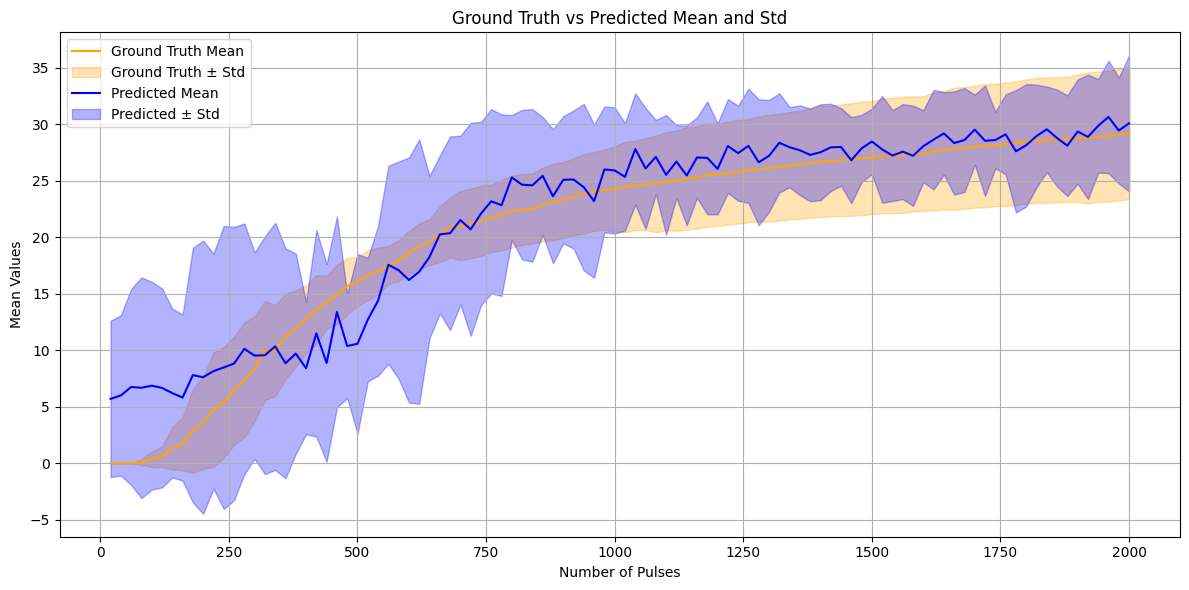

In [6]:
from torch.utils.data import Dataset, DataLoader
import glob

# --- Test Setup ---
test_images = sorted(glob.glob('BubbleSegmentation/Data/US_Test_2023April7/*.jpg'))
test_labels = sorted(glob.glob('BubbleSegmentation/Data/Labels_Test_2023April7/*.png'))
test_dataset = BubbleDataset(test_images, test_labels, augment=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


import re

def extract_pulse_and_dataset(filename):
    """
    Extracts:
    - pulse number from 'US###'
    - dataset number as the last number before '.jpg'
    Example: 't3US100_738983_1.jpg' → pulse=100, dataset=1
    """
    base = os.path.basename(filename).replace(".jpg", "")
    parts = base.split('_')
    dataset = int(parts[-1]) if parts[-1].isdigit() else -1
    pulse_match = re.search(r'US(\d+)', base)
    pulse = int(pulse_match.group(1)) if pulse_match else -1
    return pulse, dataset

from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import directed_hausdorff
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# STEP 1: Create test dataset
test_images = sorted(glob.glob('BubbleSegmentation/Data/US_Test_2023April7/*.jpg'))
test_labels = sorted(glob.glob('BubbleSegmentation/Data/Label_Test_2023April7/*.png'))


test_dataset = BubbleDataset(test_images, test_labels, augment=False)
test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)


import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
import numpy as np
import torch
import pandas as pd

def compute_area(mask):
    return (mask == 1).sum().item()

import torch
import numpy as np


import torch
import numpy as np

import numpy as np


# Function to compute per-class IoU
def compute_class_iou(preds, targets, num_classes):
    ious = []
    total_intersection = 0
    total_union = 0

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            ious.append(float('nan'))  # Undefined IoU
        else:
            ious.append(intersection / union)
            total_intersection += intersection
            total_union += union

    mean_iou = np.nanmean(ious)
    weighted_iou = total_intersection / total_union if total_union != 0 else float('nan')

    return {
        'per_class_iou': ious,
        'mean_iou': mean_iou,
        'weighted_iou': weighted_iou
    }


def visualize_prediction(img_tensor, pred_mask, true_mask, original_img_size=None, idx=None):
    img = img_tensor.cpu()
    pred = pred_mask.cpu().numpy()
    true = true_mask.cpu().numpy()

    if original_img_size is not None:
        H, W = original_img_size
        pred = TF.resize(torch.tensor(pred).unsqueeze(0).unsqueeze(0).float(), size=[H, W], interpolation=transforms.InterpolationMode.NEAREST).squeeze().numpy()
        true = TF.resize(torch.tensor(true).unsqueeze(0).unsqueeze(0).float(), size=[H, W], interpolation=transforms.InterpolationMode.NEAREST).squeeze().numpy()
        img = TF.resize(img, size=[H, W], interpolation=transforms.InterpolationMode.BILINEAR)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img[0], cmap='gray')
    axes[0].set_title('Input Image')
    axes[1].imshow(pred, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[2].imshow(true, cmap='gray')
    axes[2].set_title('Ground Truth')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# === Load best model === #
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


# === Run on val_loader === #
# Evaluation
records = []
all_mean_ious = []
total_intersection = 0
total_union = 0
n_visualize = 5  # Change as needed

# === Evaluation Loop ===

with torch.no_grad():
    for idx, (imgs, masks) in enumerate(tqdm(test_loader, desc="Evaluating on Test")):
        imgs, masks = imgs.cuda(), masks.cuda()
        outputs = model(imgs)['out']
        preds = torch.argmax(outputs, dim=1)

        if preds.shape != masks.shape:
            preds = F.interpolate(preds.unsqueeze(1).float(), size=masks.shape[-2:], mode='nearest').squeeze(1).long()

        # Compute IoU metrics
        iou_metrics = compute_class_iou(preds.cpu().numpy(), masks.cpu().numpy(), num_classes=2)
        all_mean_ious.append(iou_metrics['mean_iou'])
        total_intersection += iou_metrics['weighted_iou'] * (preds == 1).sum().item()
        total_union += (preds == 1).sum().item()

        for i in range(imgs.size(0)):
            image_name = os.path.basename(test_images[idx * test_loader.batch_size + i])
            pulse, dataset = extract_pulse_and_dataset(image_name)
            gt_area = compute_area(masks[i].cpu())
            pred_area = compute_area(preds[i].cpu())

            records.append({
                'image': image_name,
                'pulse': pulse,
                'dataset': dataset,
                'gt_area_px': gt_area,
                'pred_area_px': pred_area
            })

final_mean_iou = np.mean(all_mean_ious)
final_weighted_iou = total_intersection / total_union if total_union > 0 else float('nan')

print(f"Mean IoU (unweighted)   : {final_mean_iou:.4f}")
print(f"Weighted IoU (area)     : {final_weighted_iou:.4f}")

# === Convert to DataFrame ===
df = pd.DataFrame(records)

# Convert to mm² using correct scaling
pixel_area_mm2 = 0.005
df['gt_area_mm2'] = df['gt_area_px'] * pixel_area_mm2
df['pred_area_mm2'] = df['pred_area_px'] * pixel_area_mm2

# === Show first few entries for verification ===
print("✅ Evaluation complete. Sample entries:")
display(df.head())

# === Save to CSV ===
df.to_csv("gt_pred_areas_per_image.csv", index=False)
print("✅ Saved: gt_pred_areas_per_image.csv")

# === Optional: Group by (pulse, dataset) for plotting later ===
grouped_df = df.groupby(['pulse', 'dataset'])[['gt_area_mm2', 'pred_area_mm2']].mean().reset_index()
grouped_df.to_csv("area_grouped_by_pulse_dataset.csv", index=False)
print("✅ Saved: area_grouped_by_pulse_dataset.csv")



display(grouped_df)


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Ensure area in mm² is available
pixel_area_mm2 = 0.005
df['gt_area_mm2'] = df['gt_area_px'] * pixel_area_mm2
df['pred_area_mm2'] = df['pred_area_px'] * pixel_area_mm2

# Group by pulse and calculate mean and std across datasets
pulse_agg = df.groupby('pulse')[['gt_area_mm2', 'pred_area_mm2']].agg(['mean', 'std']).reset_index()

# Flatten column names
pulse_agg.columns = ['pulse',
                     'gt_mean', 'gt_std',
                     'pred_mean', 'pred_std']
display(pulse_agg)

pulse_agg['pulse'] = pulse_agg['pulse'].astype(int)*20
import matplotlib.pyplot as plt
import pandas as pd

# Assuming pulse_agg is already defined as your DataFrame
# If not, you can load it from CSV or another source

# Plot setup
plt.figure(figsize=(12, 6))

# Plot ground truth mean and std
plt.plot(pulse_agg['pulse'], pulse_agg['gt_mean'], label='Ground Truth Mean', color='orange')
plt.fill_between(pulse_agg['pulse'],
                 pulse_agg['gt_mean'] - pulse_agg['gt_std'],
                 pulse_agg['gt_mean'] + pulse_agg['gt_std'],
                 alpha=0.3, color='orange', label='Ground Truth ± Std')

# Plot predicted mean and std
plt.plot(pulse_agg['pulse'], pulse_agg['pred_mean'], label='Predicted Mean', color='blue')
plt.fill_between(pulse_agg['pulse'],
                 pulse_agg['pred_mean'] - pulse_agg['pred_std'],
                 pulse_agg['pred_mean'] + pulse_agg['pred_std'],
                 alpha=0.3, color='blue', label='Predicted ± Std')

# Labels and legend
plt.xlabel('Number of Pulses')
plt.ylabel('Mean Values')
plt.title('Ground Truth vs Predicted Mean and Std')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from tqdm import tqdm
import numpy as np
import torch

def compute_iou(preds, targets, num_classes=2):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)

# === Training Setup === #
# criterion = DiceFocalLoss(dice_weight=0.5, focal_weight=0.55)
class_weights = torch.tensor([0.3, 0.7])
criterion = AsymmetricFocalTverskyLoss(
    tversky_weight=0.7,
    focal_weight=0.3,
    delta=0.7
)

# criterion = AsymmetricFocalTverskyLoss(dice_weight=0.5, focal_weight=0.55)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

num_epochs = 3
best_val_iou = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for imgs, masks in train_loop:
        imgs, masks = imgs.cuda(), masks.cuda()

        optimizer.zero_grad()
        outputs = model(imgs)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)

    # === Validation === #
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validating", leave=False):
            imgs, masks = imgs.cuda(), masks.cuda()
            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_iou += compute_iou(preds.cpu(), masks.cpu())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"📊 Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val IoU = {avg_val_iou:.4f}")

    # === Scheduler Step === #
    scheduler.step(avg_val_iou)

    # === Save best model === #
    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")


TypeError: FocalLoss.__init__() got an unexpected keyword argument 'reduction'

Evaluating on Test: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s]


✅ Average IoU on Test Set: 0.7864
✅ Evaluation complete. Sample entries:


,image,pulse,dataset,gt_area_px,pred_area_px,gt_shape,pred_shape,gt_area_mm2,pred_area_mm2
0,t3US100_738983_1.jpg,100,1,7283,7558,"(256, 256)","(256, 256)",36.415,37.790
1,t3US100_738983_2.jpg,100,2,5502,6404,"(256, 256)","(256, 256)",27.510,32.020
2,t3US100_738983_3.jpg,100,3,6113,5056,"(256, 256)","(256, 256)",30.565,25.280
3,t3US100_738983_4.jpg,100,4,4486,5066,"(256, 256)","(256, 256)",22.430,25.330
4,t3US10_738983_1.jpg,10,1,14,5079,"(256, 256)","(256, 256)",0.070,25.395


✅ Saved: gt_pred_areas_per_image.csv
✅ Saved: area_grouped_by_pulse_dataset.csv


,pulse,dataset,gt_area_mm2,pred_area_mm2
0,1,1,0.000,0.000
1,1,2,0.000,8.900
2,1,3,0.000,13.975
3,1,4,0.000,0.000
4,2,1,0.000,0.000
...,...,...,...,...
395,99,4,22.340,23.115
396,100,1,36.415,37.790
397,100,2,27.510,32.020
398,100,3,30.565,25.280


,pulse,gt_mean,gt_std,pred_mean,pred_std
0,20,0.00000,0.000000,5.71875,6.920843
1,40,0.00750,0.015000,6.02000,7.093363
2,60,0.01375,0.027500,6.77000,8.675643
3,80,0.13500,0.256840,6.70250,9.766065
4,100,0.37125,0.680642,6.88375,9.199119
...,...,...,...,...,...
95,1920,28.81000,5.779177,28.90625,5.504723
96,1940,28.90750,5.774251,29.88500,4.145395
97,1960,28.97500,5.802079,30.66750,4.976620
98,1980,29.09625,5.822710,29.46750,4.689141


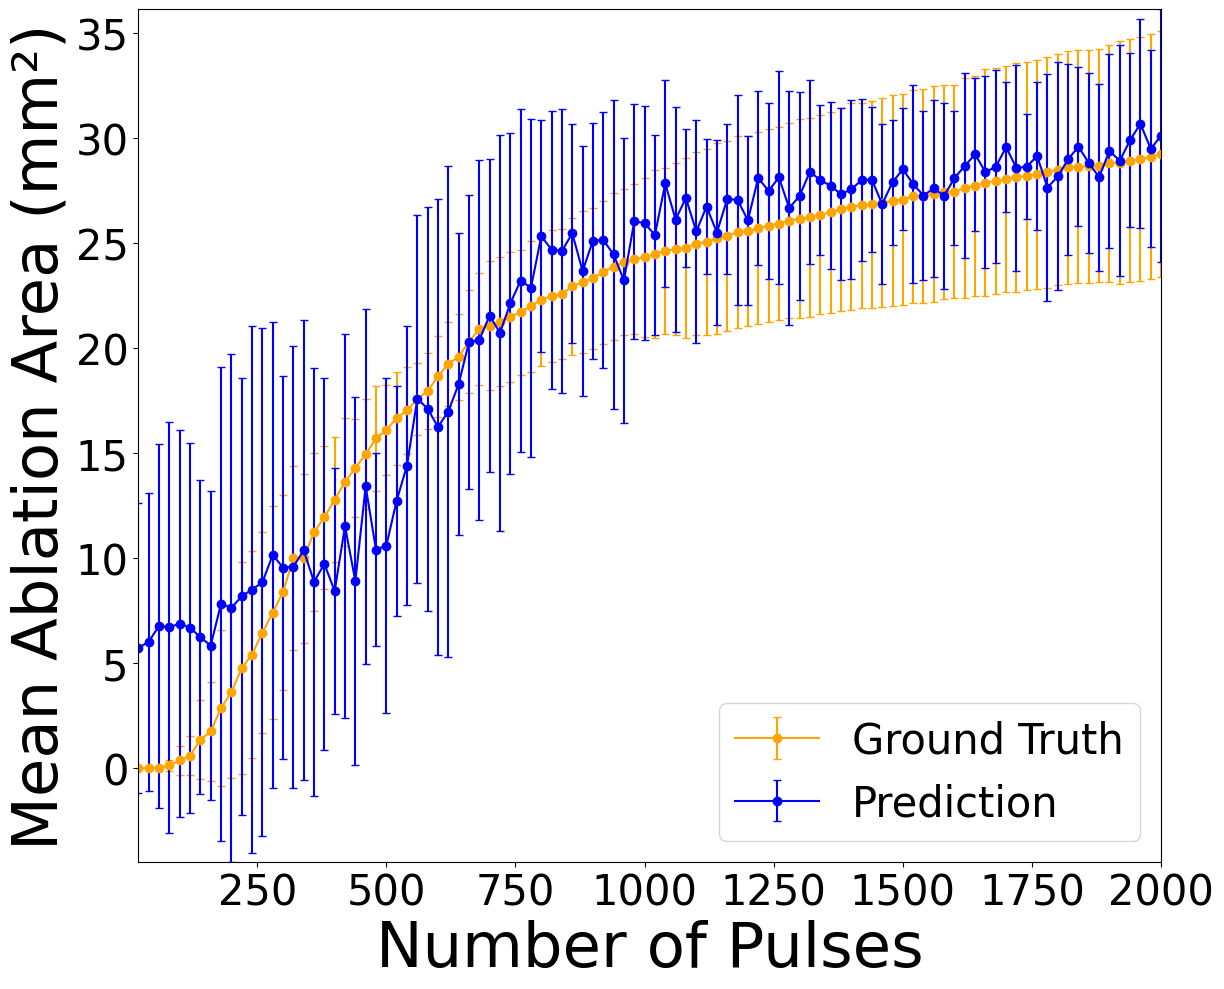

✅ Saved: area_vs_pulses.png


In [7]:

# --- Test Setup ---
test_images = sorted(glob.glob('BubbleSegmentation/Data/US_Test_2023April7/*.jpg'))
test_labels = sorted(glob.glob('BubbleSegmentation/Data/Label_Test_2023April7/*.png'))
test_dataset = BubbleDataset(test_images, test_labels, augment=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


import re

def extract_pulse_and_dataset(filename):
    """
    Extracts:
    - pulse number from 'US###'
    - dataset number as the last number before '.jpg'
    Example: 't3US100_738983_1.jpg' → pulse=100, dataset=1
    """
    base = os.path.basename(filename).replace(".jpg", "")
    parts = base.split('_')
    dataset = int(parts[-1]) if parts[-1].isdigit() else -1
    pulse_match = re.search(r'US(\d+)', base)
    pulse = int(pulse_match.group(1)) if pulse_match else -1
    return pulse, dataset

from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import directed_hausdorff
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# STEP 1: Create test dataset
test_images = sorted(glob.glob('BubbleSegmentation/Data/US_Test_2023April7/*.jpg'))
test_labels = sorted(glob.glob('BubbleSegmentation/Data/Label_Test_2023April7/*.png'))


test_dataset = BubbleDataset(test_images, test_labels, augment=False)
test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)


import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
import numpy as np
import torch
import pandas as pd

def compute_area(mask):
    return (mask == 1).sum().item()

def compute_iou(preds, targets, num_classes=2):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)


def visualize_prediction(img_tensor, pred_mask, true_mask, original_img_size=None, idx=None):
    img = img_tensor.cpu()
    pred = pred_mask.cpu().numpy()
    true = true_mask.cpu().numpy()

    if original_img_size is not None:
        H, W = original_img_size
        pred = TF.resize(torch.tensor(pred).unsqueeze(0).unsqueeze(0).float(), size=[H, W], interpolation=transforms.InterpolationMode.NEAREST).squeeze().numpy()
        true = TF.resize(torch.tensor(true).unsqueeze(0).unsqueeze(0).float(), size=[H, W], interpolation=transforms.InterpolationMode.NEAREST).squeeze().numpy()
        img = TF.resize(img, size=[H, W], interpolation=transforms.InterpolationMode.BILINEAR)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img[0], cmap='gray')
    axes[0].set_title('Input Image')
    axes[1].imshow(pred, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[2].imshow(true, cmap='gray')
    axes[2].set_title('Ground Truth')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()



# === Load best model === #
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

'''
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
import numpy as np
import torch

def compute_iou(preds, targets, num_classes=2):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)


def visualize_prediction(img_tensor, pred_mask, true_mask, original_img_size=None, idx=None, filename=None):
    img = img_tensor.cpu()
    pred = pred_mask.cpu().numpy()
    true = true_mask.cpu().numpy()

    if original_img_size is not None:
        H, W = original_img_size
        pred = TF.resize(torch.tensor(pred).unsqueeze(0).unsqueeze(0).float(), size=[H, W], interpolation=transforms.InterpolationMode.NEAREST).squeeze().numpy()
        true = TF.resize(torch.tensor(true).unsqueeze(0).unsqueeze(0).float(), size=[H, W], interpolation=transforms.InterpolationMode.NEAREST).squeeze().numpy()
        img = TF.resize(img, size=[H, W], interpolation=transforms.InterpolationMode.BILINEAR)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    if filename:
        fig.suptitle(f"Sample {idx} – {filename}", fontsize=12)

    axes[0].imshow(img[0], cmap='gray')
    axes[0].set_title('Input Image')
    axes[1].imshow(pred, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[2].imshow(true, cmap='gray')
    axes[2].set_title('Ground Truth')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()



# === Load best model === #
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# === Run on val_loader === #
all_ious = []
n_visualize = 5  # Change as needed

with torch.no_grad():
    for batch_idx, (imgs, masks) in enumerate(tqdm(val_loader, desc="Evaluating on Val")):
        imgs, masks = imgs.cuda(), masks.cuda()
        outputs = model(imgs)['out']
        preds = torch.argmax(outputs, dim=1)

        for i in range(imgs.size(0)):
            iou = compute_iou(preds[i].cpu(), masks[i].cpu())
            all_ious.append(iou)

            global_idx = batch_idx * val_loader.batch_size + i
            if global_idx < n_visualize:
                filename = os.path.basename(val_images[global_idx])  # assumes val_images is defined
                visualize_prediction(imgs[i], preds[i], masks[i], original_img_size=(256, 1024), idx=global_idx, filename=filename)

avg_iou = np.nanmean(all_ious)
print(f"✅ Average IoU on Validation Set: {avg_iou:.4f}")


'''

# === Run on val_loader === #
all_ious = []
n_visualize = 5  # Change as needed

# === Evaluation Loop ===
records = []

with torch.no_grad():
    for idx, (imgs, masks) in enumerate(tqdm(test_loader, desc="Evaluating on Test")):
        imgs, masks = imgs.cuda(), masks.cuda()
        outputs = model(imgs)['out']
        preds = torch.argmax(outputs, dim=1)

        for i in range(imgs.size(0)):
            iou = compute_iou(preds[i], masks[i])
            all_ious.append(iou)
            image_name = os.path.basename(test_images[idx * test_loader.batch_size + i])
            label_name = os.path.basename(test_labels[idx * test_loader.batch_size + i])
            pulse, dataset = extract_pulse_and_dataset(image_name)

            # Resize prediction if shape doesn't match GT
            pred = preds[i]
            gt = masks[i]

            if pred.shape != gt.shape:
                pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0).float(), size=gt.shape[-2:], mode='nearest').squeeze().long()

            # Compute area on correctly sized masks
            gt_area = compute_area(gt.cpu())
            pred_area = compute_area(pred.cpu())

            records.append({
                'image': image_name,
                'pulse': pulse,
                'dataset': dataset,
                'gt_area_px': gt_area,
                'pred_area_px': pred_area,
                'gt_shape': tuple(gt.shape),
                'pred_shape': tuple(preds[i].shape)
            })

avg_iou = np.nanmean(all_ious)
print(f"\n✅ Average IoU on Test Set: {avg_iou:.4f}")

# === Convert to DataFrame ===
df = pd.DataFrame(records)

# Convert to mm² using correct scaling
pixel_area_mm2 = 0.005
df['gt_area_mm2'] = df['gt_area_px'] * pixel_area_mm2
df['pred_area_mm2'] = df['pred_area_px'] * pixel_area_mm2

# === Show first few entries for verification ===
print("✅ Evaluation complete. Sample entries:")
display(df.head())

# === Save to CSV ===
df.to_csv("gt_pred_areas_per_image.csv", index=False)
print("✅ Saved: gt_pred_areas_per_image.csv")

# === Optional: Group by (pulse, dataset) for plotting later ===
grouped_df = df.groupby(['pulse', 'dataset'])[['gt_area_mm2', 'pred_area_mm2']].mean().reset_index()
grouped_df.to_csv("area_grouped_by_pulse_dataset.csv", index=False)
print("✅ Saved: area_grouped_by_pulse_dataset.csv")



display(grouped_df)


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure area in mm² is available
pixel_area_mm2 = 0.005
df['gt_area_mm2'] = df['gt_area_px'] * pixel_area_mm2
df['pred_area_mm2'] = df['pred_area_px'] * pixel_area_mm2

# Group by pulse and calculate mean and std across datasets
pulse_agg = df.groupby('pulse')[['gt_area_mm2', 'pred_area_mm2']].agg(['mean', 'std']).reset_index()

# Flatten column names
pulse_agg.columns = ['pulse', 'gt_mean', 'gt_std', 'pred_mean', 'pred_std']

# Optional scaling pulse number if needed
pulse_agg['pulse'] = pulse_agg['pulse'].astype(int) * 20  # if pulse = 5 means 100 pulses

display(pulse_agg)

plt.figure(figsize=(12, 10))

# Ground Truth
plt.errorbar(pulse_agg['pulse'], pulse_agg['gt_mean'], yerr=pulse_agg['gt_std'],
             fmt='-o', label='Ground Truth', color='orange', capsize=3)

# Predicted
plt.errorbar(pulse_agg['pulse'], pulse_agg['pred_mean'], yerr=pulse_agg['pred_std'],
             fmt='-o', label='Prediction', color='blue', capsize=3)

plt.xlabel('Number of Pulses', fontsize = 45)
plt.ylabel('Mean Ablation Area (mm²)', fontsize = 45)
# plt.title('Ground Truth vs Predicted Ablation Area vs Pulses', fontsize = 22)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)
# plt.grid(True)
plt.tight_layout()
min_pulse = pulse_agg['pulse'].min()
max_pulse = pulse_agg['pulse'].max()
plt.xlim(min_pulse, max_pulse)

y_min = min((pulse_agg['gt_mean'] - pulse_agg['gt_std']).min(), 
            (pulse_agg['pred_mean'] - pulse_agg['pred_std']).min())
y_max = max((pulse_agg['gt_mean'] + pulse_agg['gt_std']).max(), 
            (pulse_agg['pred_mean'] + pulse_agg['pred_std']).max())
plt.ylim(y_min, y_max)

plt.savefig('area_vs_pulses.png', dpi=300)
plt.show()

print("✅ Saved: area_vs_pulses.png")


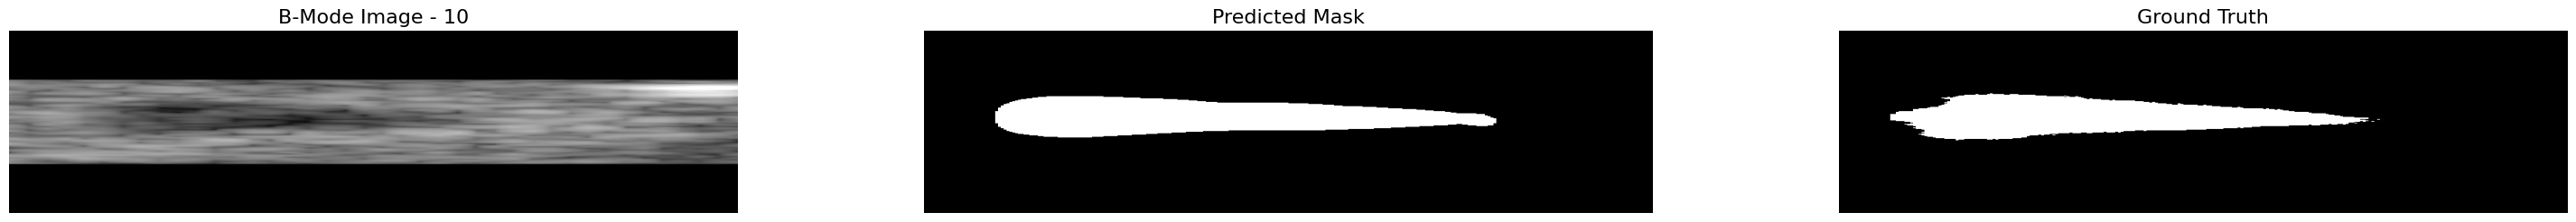

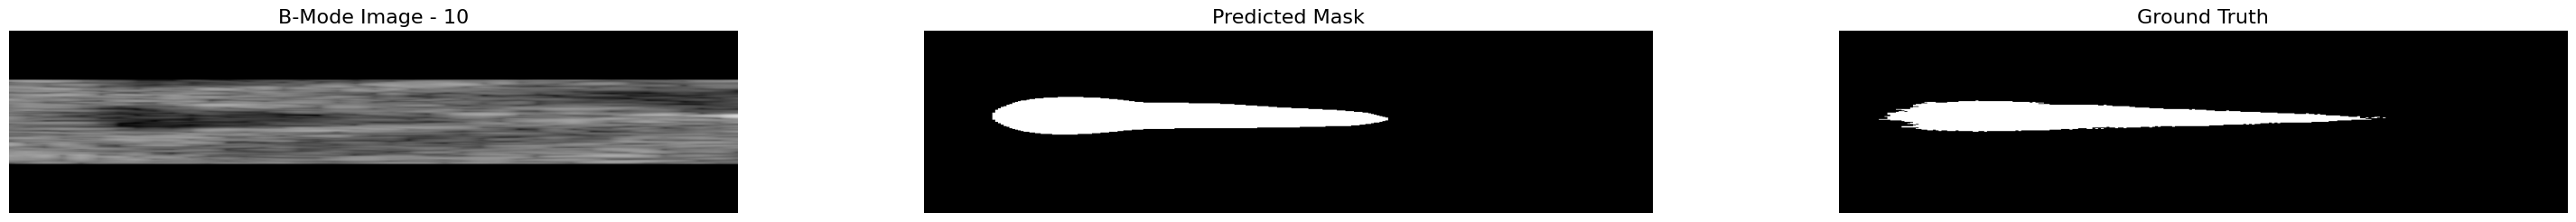

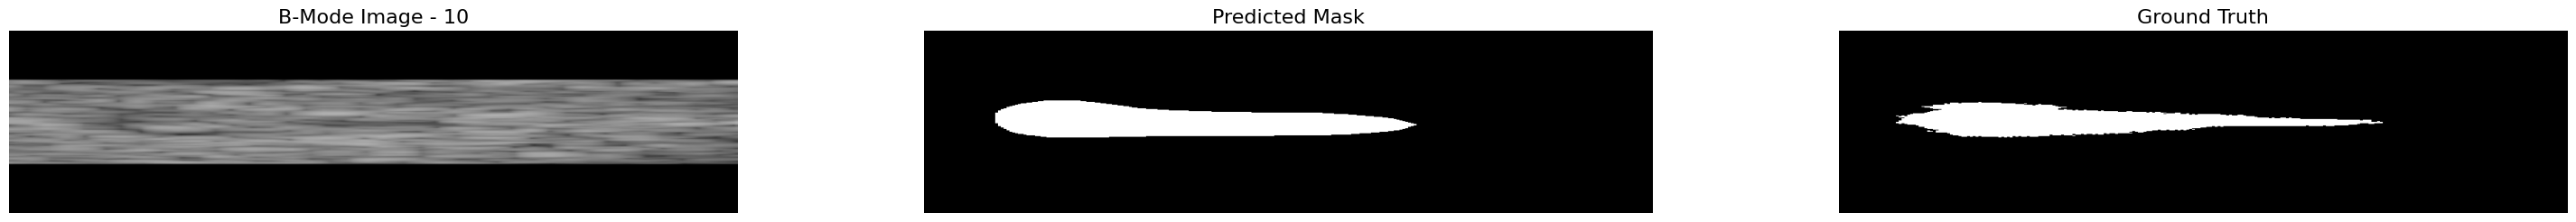

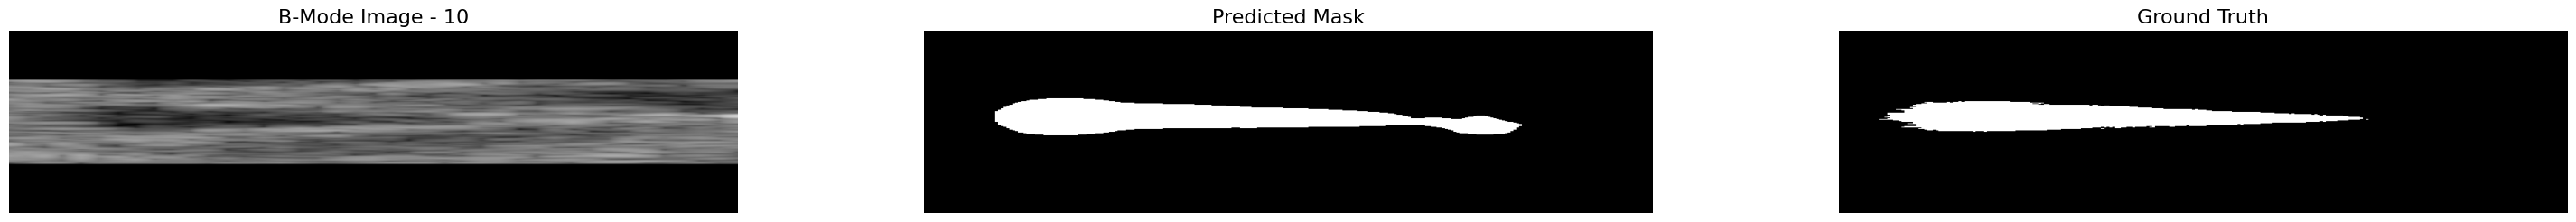

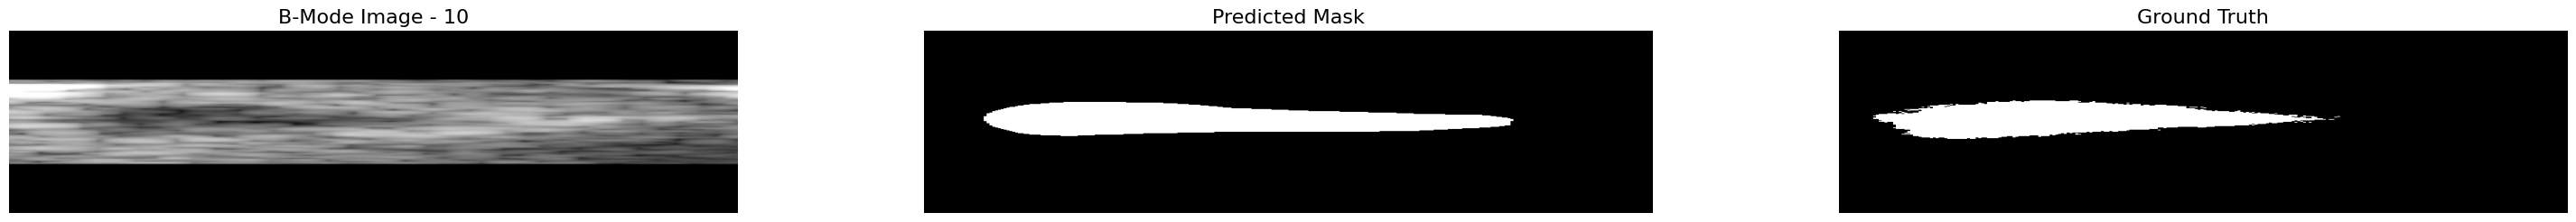

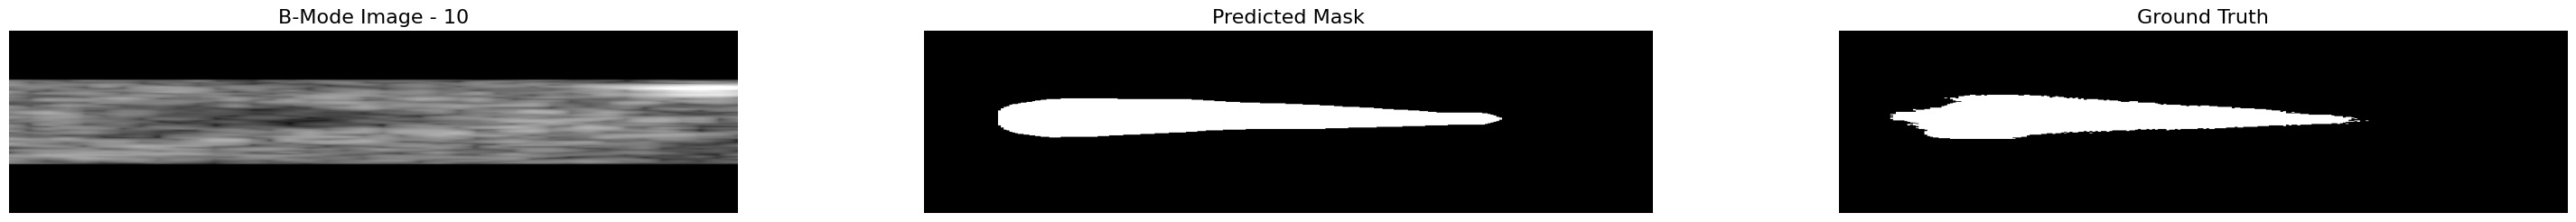

In [10]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# --- Visualize Predictions ---
def visualize_prediction(img_tensor, pred_mask, true_mask, original_img_size=(256, 1024), idx=None, pulse = None):
    img = img_tensor.cpu().detach()
    pred = pred_mask.cpu().detach()
    true = true_mask.cpu().detach()
    

    H, W = original_img_size

    # Resize predictions and labels back to original size
    pred_resized = TF.resize(
        pred.unsqueeze(0).unsqueeze(0).float(),
        size=[H, W],
        interpolation=transforms.InterpolationMode.NEAREST
    ).squeeze(0).squeeze(0).long().numpy()

    true_resized = TF.resize(
        true.unsqueeze(0).unsqueeze(0).float(),
        size=[H, W],
        interpolation=transforms.InterpolationMode.NEAREST
    ).squeeze(0).squeeze(0).long().numpy()

    img_resized = TF.resize(img, size=[H, W], interpolation=transforms.InterpolationMode.BILINEAR)

    # Prepare image for imshow
    if img_resized.ndim == 3:
        if img_resized.shape[0] == 1:
            img_disp = img_resized.squeeze(0).numpy()  # Grayscale
        else:
            img_disp = img_resized.permute(1, 2, 0).numpy()  # CHW to HWC
    else:
        img_disp = img_resized.numpy()

    # Plotting
    dpi = 100
    fig_width = W / dpi * 3
    fig_height = H / dpi

    fig, axes = plt.subplots(1, 3, figsize=(fig_width, fig_height), dpi=dpi)

    axes[0].imshow(img_disp, cmap='gray' if img_disp.ndim == 2 else None)
    axes[0].set_title(f'B-Mode Image - {pulse}', fontsize = 16)

    axes[1].imshow(pred_resized, cmap='gray')
    axes[1].set_title('Predicted Mask', fontsize = 16)

    axes[2].imshow(true_resized, cmap='gray')
    axes[2].set_title('Ground Truth', fontsize = 16)



    for ax in axes:
        ax.axis('off')

    plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05)
    plt.tight_layout()

    if idx is not None:
        plt.savefig(f"prediction_{idx}.png", dpi=dpi, bbox_inches='tight')

    plt.show()


# Wrapper with correct original image size
def plot_image_gt_pred(img, gt, pred, idx=None, pulse = None):
    visualize_prediction(img, pred, gt, original_img_size=(256, 1024), idx=idx, pulse=pulse)


# --- Reload a few batches for visualization ---
visual_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

model.eval()
with torch.no_grad():
    for idx, (imgs, masks) in enumerate(visual_loader):
        imgs, masks = imgs.cuda(), masks.cuda()
        outputs = model(imgs)['out']
        preds = torch.argmax(outputs, dim=1)
        image_name = os.path.basename(test_images[idx * visual_loader.batch_size + i])
        label_name = os.path.basename(test_labels[idx * visual_loader.batch_size + i])
        pulse, dataset = extract_pulse_and_dataset(image_name)
        for i in range(min(imgs.size(0), 6)):
            img = imgs[i]
            gt = masks[i]
            pred = preds[i]

            # Optional safety resize (if needed)
            if pred.shape != gt.shape:
                pred = F.interpolate(
                    pred.unsqueeze(0).unsqueeze(0).float(),
                    size=gt.shape[-2:],
                    mode='nearest'
                ).squeeze().long()

            plot_image_gt_pred(img, gt, pred, i, pulse)

        break  # visualize only one batch
